# Homework 5

In this homework, you'll review some linear algebra, and practice using `scipy.optimize` to solve several variations of linear models.  

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import scipy

## Linear Models

A standard problem in statistics to solve the multivariate linear regression problem.
\begin{equation}
y = X * \beta + \epsilon
\end{equation}
The above notation is standard in statistics, but in our discussion (and codes) we will replace $\beta$ with `b`
```
y = X * b + eps.
```
`X` is known as the [design matrix](https://en.wikipedia.org/wiki/Design_matrix), and consists of `n` rows of observations, each of which has `p` features (so it is an $n\times p$ matrix).  `y` is a vector of `n` responses.  `b` is an unknown vector of `p` coefficients which we would like to find.  `eps` (epsilon) is a vector of length `n` with random noise, typically i.i.d. normally distributed with variance `sig` (sigma).

In numpy notation, we could express this as
```python
y[i] = np.dot(X[i], b) + sig * np.random.randn()
```

We want to determine `b`, so that when me make a new observation `X[n]` we can predict the response `y[n]`.  One way to do this is to minimize the mean square error

\begin{equation}
\mathop{\mathsf{minimize}}_b \mathbb{E}((X[n]*b - y[n])^2)
\end{equation}

The solution to this is the solution to the least squares problem
\begin{equation}
\mathop{\mathsf{minimize}}_b \frac{1}{n} \|X*b - y\|_2^2
\end{equation}

Where $n$ is the number of rows in $X$.  We'll let the solution to the problem be denoted $\hat{b}$, or `bhat`.

## Problem 0 - Linear Regression (37 points)

There are a variety of ways to solve the above problem.  We will assume that $n > p$, meaning there are more observations than features.

### Part A: Generating Data (5 points)

Write a function `gen_lstsq(n, p, sig=0.1)` which will generate a linear least squares problem (return `X`, `y`, and `b` as described above).  `b` is the "ground truth" coefficients that we are looking for.  You can generate the matrix `X` using `np.random.randn`, and generate `b` using `np.random.randn` as well. 


In [60]:
def gen_lstsq(n, p, sig = 0.1):
    """
    Generates a random (standard normal) least squares problem with n observations and p features.

    Parameters:
    n is the number of observations.
    p is the number of features.
    sig is the variance of the normally distributed error term.

    Returns:
    y, an ndarray containing n observations of the regressand.
    X, an ndarray representing the (n x p) design matrix with random entries distributed N(0, 1).
    b, an ndarray containing the coefficients of the p features.
    """
    X = np.random.randn(n, p)
    b = np.random.randn(p)
    eps = sig * np.random.randn(n)
    y = X @ b + eps

    return y, X, b

### Part B: QR factorization (3 points)

If we form a QR factorization $X = QR$, we can find $\hat{b} = R^{-1} Q^T y$.

Write a function `solve_lstsq_qr(X, y)` which estimates `b` using the QR factorization as above. 

In [61]:
def solve_lstsq_qr(X, y):
    """
    Estimates bhat using the QR factorization.

    Parameters:
    X is an ndarray representing the (n x p) design matrix.
    y is an ndarray containing n observations of the regressand.

    Returns:
    bhat, an ndarray containing the coefficient estimates of the p features.
    """
    Q, R = la.qr(X, mode = "economic")
    bhat = la.solve_triangular(R, Q.T @ y, lower = False)
    return bhat

### Part C: Normal Equations (3 points)

Often, this is the way statistics textbooks solve the problem: $\hat{b} = (X^T X)^{-1} X^T y$.  This is based on the normal equation $X^T X \hat{b} = X^T y$.

Write a function `solve_lstsq_normal(X, y)` which estimates `b` using the normal equations above. Note that forming the full inverse would be slow and unstable. Instead, you should try to apply $(X^TX)^{-1}$ by forming a Cholesky factorization instead.

In [62]:
def solve_lstsq_normal(X, y):
    """
    Estimates bhat using the normal equations and the Cholesky decomposition.

    Parameters:
    X is an ndarray representing the (n x p) design matrix.
    y is an ndarray containing n observations of the regressand.

    Returns:
    bhat, an ndarray containing the coefficient estimates of the p features.
    """
    XTX = X.T @ X
    XTy = X.T @ y
    L = la.cholesky(XTX, lower = True)
    LTb = la.solve_triangular(L, XTy, lower = True)
    bhat = la.solve_triangular(L.T, LTb, lower = False)
    return bhat

### Part D: Check Your Work (3 points)

Generate a few random problems to test that `solve_lstsq_qr` and `solve_lstsq_normal` give the same prediction $\hat{b}$ (measure $\|\hat{b}_{qr} - \hat{b}_{normal}\|_2$ and check it is smaller than `1e-4`).  Use $n > p$.  Check against `solve_lstsq` in numpy or scipy as well.

-----------------

All three of our methods (`solve_lstsq_qr`, `solve_lstsq_normal`, and SciPy's built-in `solve_lstsq`) yield very close estimates for `bhat`. In fact, as shown below, the 2-norm of the difference in estimates of `bhat` across any pair of these approaches is typically on the order of `1e-14` or `1e-15` or better, well below our target `1e-4` cutoff.

In [63]:
# Demonstrate that our least squares functions work for a handful of random problems
num_tests = 3

for i in range(num_tests):
    # Randomly generate n and p < n
    n = np.random.randint(2, 11)
    p = np.random.randint(1, n)

    # Generate a random least squares problem with n observations, p features
    y, X, b = gen_lstsq(n, p)

    # Three different methods for obtaining least squares solution
    bhat_scipy = la.lstsq(X, y)[0]
    bhat_qr = solve_lstsq_qr(X, y)
    bhat_normal = solve_lstsq_normal(X, y)
    bhats = np.array([bhat_scipy, bhat_qr, bhat_normal])

    # Print norms of differences among our three methods
    print("Test ", i, ":", sep = "")
    print("Norm of Difference Between SciPy Function and QR Method Solutions:", la.norm(bhats[0] - bhats[1], 2))
    print("Norm of Difference Between SciPy Function and Normal Equation Method Solutions:", la.norm(bhats[0] - bhats[2], 2))
    print("Norm of Difference Between QR Method and Normal Equation Method Solutions:", la.norm(bhats[1] - bhats[2], 2))
    print("\n")

# print(la.lstsq(X, y)[0])
# print(bhat_qr)
# print(bhat_normal)

Test 0:
Norm of Difference Between SciPy Function and QR Method Solutions: 0.0
Norm of Difference Between SciPy Function and Normal Equation Method Solutions: 0.0
Norm of Difference Between QR Method and Normal Equation Method Solutions: 0.0


Test 1:
Norm of Difference Between SciPy Function and QR Method Solutions: 0.0
Norm of Difference Between SciPy Function and Normal Equation Method Solutions: 5.551115123125783e-17
Norm of Difference Between QR Method and Normal Equation Method Solutions: 5.551115123125783e-17


Test 2:
Norm of Difference Between SciPy Function and QR Method Solutions: 2.112525708040994e-15
Norm of Difference Between SciPy Function and Normal Equation Method Solutions: 7.646446993452937e-15
Norm of Difference Between QR Method and Normal Equation Method Solutions: 6.031395788833947e-15




### Part E: Estimate the Error (6 points)

Write a function `err` which estimates the error in your fit using the equation $\frac{1}{n}\|X * \hat{b} - y\|_2^2$. The function should have the call signature `err(X,y,bhat).` 

Create a plot of the error vs the noise parameter `sig` (i.e. use your code from the previous parts to generate $y,$ $\hat{b},$ and $X$ for various $\sigma \in[10^{-4},10]$ and use `err` to compute the corresponding error).  Use `n=100`, `p=50` when generating data.  Put your plot on log-log axes.  Give it a title and axis labels.

As above, you should generate `X` to be `N x p` using `np.random.randn`, and set `y = X * b + sig * np.random.randn(p)`. Note: when choosing `sig` on $[10^{-4},10]$ it would help if you gave them a logarithmic distribution (like taking equispaced points $t_0,\dots,t_N$ between -4 and 1, and setting $\sigma_0 =10^{t_0},\dots, \sigma_N = 10^{t_n}.$

Try to make smoother plots by averaging the error over several trials.


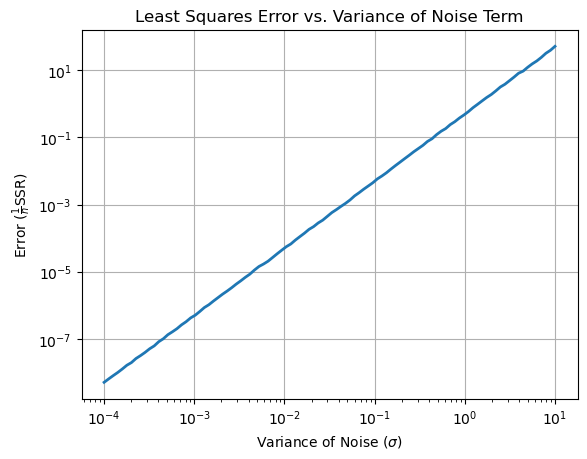

In [64]:
def err(X, y, bhat):
    """
    Estimates the error in a regression fit using the sum over squared residuals (SSR) over n.

    Parameters:
    X is an ndarray representing the (n x p) design matrix.
    y is an ndarray containing n observations of the regressand.
    bhat is an ndarray containing the coefficient estimates of the p features.

    Returns:
    SSR_n, a float calculated as the sum of squared residuals of our fit, divided by the number of observations in the data.
    """
    # Compute additional variables (number of observations, predicted values, residuals)
    n = len(y)
    yhat = X @ bhat
    eps_hat = yhat - y
    # Compute and return error
    SSR_n = (la.norm(eps_hat, ord = 2)**2) / n
    return SSR_n

# Parameters of randomly-generated least squares problems
n = 100
p = 50

# We consider 100 noise terms with variances logarithmically spaced between 1e-4 and 1e1
sigs = np.logspace(-4, 1, 100)
# Initialize empty array of 100 corresponding errors
errors = np.zeros(len(sigs))

# Compute average errors (across several trials) for each level of noise (sigma)
for i in range(len(sigs)):
    # Run 100 trials per given level of noise (i.e., per sigma) and compute the average error to smooth out plot
    errors_given_sig = np.zeros(100)
    for j in range(len(errors_given_sig)):
        y, X, b = gen_lstsq(n, p, sigs[i])
        bhat = solve_lstsq_qr(X, y)
        errors_given_sig[j] = err(X, y, bhat)
    errors[i] = np.mean(errors_given_sig)

# Plotting
plt.plot(sigs, errors, linewidth = 2)
plt.xlabel(r"Variance of Noise ($\sigma$)")
plt.ylabel(r"Error ($\frac{1}{n}$SSR)")
plt.title("Least Squares Error vs. Variance of Noise Term")
plt.loglog()
plt.grid()


### Part F: Discussion (10 points)

Which of `solve_lstsq_qr` and `solve_lstsq_normal` is faster?  Give a justification for your answer (e.g. in terms of what you know about time to compute matrix multiplication and factorizations as a function of $n$ and $p$).

Suppose that $\kappa(X)$ is large. Which of `solve_lstsq_qr` and `solve_lstsq_normal` will be more stable? i.e. which of $\hat{b} = R^{-1} Q^T y$ and $\hat{b} = (X^T X)^{-1} X^T y$ has a smaller condition number? Use the fact that the matrix condition number satisfies
$$
\kappa(A^{-1}) = \kappa(A), \qquad \kappa(A^T) = \kappa(A), \qquad \kappa(AB) \approx \kappa(A)\kappa(B),
$$
and that
$$
\kappa(Q) = 1
$$
because the columns of $Q$ are orthonormal. You should also use the fact that for most $A$ and $B$
$$
\kappa(AB) \approx \kappa(A)\kappa(B).
$$
Note that there are counter examples, e.g. $1=\kappa(I)=\kappa(AA^{-1})< \kappa(A)\kappa(A^{-1})=\kappa(A)^2$ whenever $\kappa(A)>1$.

In [65]:
import time # to compute runtimes
from tqdm import tqdm # progress bar

# Randomly generate n and p < n
n = np.random.randint(2, 100)
p = np.random.randint(1, n)

y, X, b = gen_lstsq(n, p)

ts = []

fs = np.array([solve_lstsq_qr, solve_lstsq_normal])
for i in range(len(fs)):
    t0 = time.time()
    bhat = fs[i](X, y)
    t1 = time.time()
    ts.append(t1 - t0)

print("QR Approach Runtime:\t\t\t", ts[0])
print("Normal Equation Approach Runtime:\t", ts[1])

QR Approach Runtime:			 0.003590822219848633
Normal Equation Approach Runtime:	 0.00023126602172851562


--------------------------

**(I) Speed**

As shown above, our normal equation approach to solving a least squares problem is faster than our QR factorization approach. This is because...

Our QR factorization approach involves:
* The QR factorization of the $n \times p$ matrix $X$, which is $O(2np^2)$ (see, *e.g.*, https://ics.uci.edu/~xhx/courses/CS206/NLA-QR.pdf),
* The matrix-vector product $Q^T y$, where $Q^T$ is $p \times n$ and $y$ is $n \times 1$, which is $O(np)$, and
* Solving the triangular system $R \hat{b} = Q^T y$, where $R$ is $p \times p$ and $\hat{b}$ and $Q^T y$ are each $p \times 1$, which is $O(p^2)$.

Thus, the overall computational complexity of `solve_lstsq_qr` is $O(2np^2 + np + p^2) = O(2np^2)$.

Meanwhile, our normal equation approach involves:
* The matrix-matrix product $X^T X$, where $X$ is $n \times p$, which is $O(np^2)$,
* The matrix-vector product $X^T y$, where $X$ is $n \times p$ and $y$ is $n \times 1$, which is $O(np)$,
* The Cholesky decomposition of the $p \times p$ matrix $X^T X$, which is $O(p^3)$,
* Solving the triangular system $L \times L^T \hat{b} = (X^T y)$, where $L$ is $p \times p$ and $(X^T y)$ is $p \times 1$, which is $O(p^2)$, and
* Solving the triangular system $L^T \hat{b} = L^{-1} (X^T y)$, where $L$ is $p \times p$ and $L^{-1} (X^T y)$ is $p \times 1$, which is $O(p^2)$.

Thus, the overall computational complexity of `solve_lstsq_normal` is $O(np^2 + np + p^3 + 2p^2) = O(np^2 + p^3) = O(np^2)$, since $p < n$.

As such, our normal equation approach (`solve_lstsq_normal`) is computationally faster than our QR factorization approach (`solve_lstsq_qr`), as we illustrated through the example above.

**(II) Stability**

The condition number for the matrix of $\hat{b} = R^{-1} Q^T y$ is:
$$
\kappa(R^{-1} Q^T) \approx \kappa(R^{-1})\kappa(Q^T) = \kappa(R)\kappa(Q) = \kappa(R) \times 1 = \kappa(R),
$$
but since we factorized $X = QR$, we have
$$
\kappa(X) = \kappa(QR) \approx \kappa(Q)\kappa(R) = 1 \times \kappa(R) = \kappa(R),
$$
so that
$$
\kappa(R^{-1} Q^T) = \kappa(R) = \kappa(X).
$$

Meanwhile, the condition number for the matrix of $\hat{b} = (X^T X)^{-1} X^T y$ is:
$$
\kappa((X^T X)^{-1} X^T) \approx \kappa((X^T X)^{-1})\kappa(X^T) = \kappa(X^T X)\kappa(X^T) \approx \kappa(X^T)\kappa(X)\kappa(X^T) = \kappa(X)\kappa(X)\kappa(X) = \kappa(X)^3.
$$

Since we are assuming that $\kappa(X)$ is large, it is clear that $\kappa(X) < \kappa(X)^3$. Thus, our function for solving a least squares problem using the QR factorization (`solve_lstsq_qr`) is (significantly) more stable than our function for solving a least squares problem using the normal equations (`solve_lstsq_normal`).

### Part G: Optimization (5 points)

Solve the minimization problem 
\begin{equation}
\mathop{\mathsf{minimize}}_b \frac{1}{n}\|X*b - y\|_2^2
\end{equation}

using `scipy.optimize.minimize`.  Wrap this in a function `solve_lstsq_opt(X, y)`.  Note that you can define the objective function inside `solve_lstsq_opt`

**Jacobian**: you should implement the Jacobian of the objective function to use in the optimization problem.  Here's a derivation:  We'd like to minimize the objective function
\begin{equation}
n f(b) = \|X*b - y\|_2^2 = (Xb - y)^T (Xb - y) = b^T X^T X b - 2 y^T X b + y^T y
\end{equation}

We might write the above expression as
\begin{equation}
n f(b) \sum_{i,j} b_i (X^T X)_{i,j} b_j - 2\sum_{j,i} y_i X_{i,j} b_j + y^T y
\end{equation}

We can take a derivative with respect to $b_j$
\begin{equation}
n \frac{\partial f}{\partial b_j} = \sum_{i\ne j} b_i (X^T X)_{i,j} + \sum_{i\ne j} (X^T X)_{j,i} b_i + 2 (X^T X)_{j,j} b_j  - 2\sum_{i} y_i X_{i,j}
\end{equation}

Putting this in matrix form, we obtain
\begin{equation}
J_f(b) =  \frac{1}{n}\big( b^T (X^T X) + b^T (X^T X)^T - 2y^T X\big) = \frac{2}{n} b^T (X^T X) -\frac{2}{n}y^T X
\end{equation}

So we can write $J_f(b) = \frac{2}{n} b^T (X^T X) -\frac{2}{n} y^T X$

In [66]:
def solve_lstsq_opt(X, y):
    """
    Estimates bhat using a minimization approach.

    Parameters:
    X is an ndarray representing the (n x p) design matrix.
    y is an ndarray containing n observations of the regressand.

    Returns:
    bhat, an ndarray containing the coefficient estimates of the p features.
    """
    n = len(y)
    obj_fcn = lambda b : (la.norm(X @ b - y, ord = 2)**2) / n
    
    # Initial guess is simply the zero vector
    zero = np.zeros(len(X[0]))

    # Jacobian
    Jf = lambda b : (2/n * b.T @ (X.T @ X)) - (2/n * y.T @ X)
    
    soln = scipy.optimize.minimize(obj_fcn, zero, jac = Jf)
    bhat = soln.x
    return bhat
    

#### Check Your Work

Generate a few random problems to test that `solve_lstsq_opt` agrees with `solve_lstsq_qr` and `solve_lstsq_normal` in part A.  Use the same tolerance for checking.

----------------------

All four of our methods (`solve_lstsq_qr`, `solve_lstsq_normal`, `solve_lstsq_opt`, and SciPy's built-in `solve_lstsq`) yield very close estimates for `bhat`. In fact, as shown below, the 2-norm of the difference in estimates of `bhat` across any pair of these approaches is at most on the order of `1e-5`, better than our `1e-4` cutoff.

In [67]:
# Demonstrate that our least squares functions work for a handful of random problems
num_tests = 3

for i in range(num_tests):
    # Randomly generate n and p < n
    n = np.random.randint(2, 11)
    p = np.random.randint(1, n)

    # Generate a random least squares problem with n observations, p features
    y, X, b = gen_lstsq(n, p)

    # Four different methods for obtaining least squares solution
    bhat_scipy = la.lstsq(X, y)[0]
    bhat_qr = solve_lstsq_qr(X, y)
    bhat_normal = solve_lstsq_normal(X, y)
    bhat_opt = solve_lstsq_opt(X, y)
    bhats = np.array([bhat_scipy, bhat_qr, bhat_normal, bhat_opt])

    # print(la.lstsq(X, y)[0])
    # print(bhat_qr)
    # print(bhat_normal)
    # print(bhat_opt)
    # print("\n")

    # Print norms of differences among our three methods (excluding the built-in SciPy function, which we already checked against in Part (D))
    print("Test ", i, ":", sep = "")
    print("Norm of Difference Between SciPy Function and QR Method Solutions:", la.norm(bhats[0] - bhats[1], 2))
    print("Norm of Difference Between SciPy Function and Normal Equation Method Solutions:", la.norm(bhats[0] - bhats[2], 2))
    print("Norm of Difference Between SciPy Function and Optimization Method Solutions:", la.norm(bhats[0] - bhats[3], 2))
    print("Norm of Difference Between QR Method and Normal Equation Method Solutions:", la.norm(bhats[1] - bhats[2], 2))
    print("Norm of Difference Between QR Method and Optimization Method Solutions:", la.norm(bhats[1] - bhats[3], 2))
    print("Norm of Difference Between Normal Equation Method and Optimization Method Solutions:", la.norm(bhats[2] - bhats[3], 2))
    print("\n")



Test 0:
Norm of Difference Between SciPy Function and QR Method Solutions: 0.0
Norm of Difference Between SciPy Function and Normal Equation Method Solutions: 1.6653345369377348e-16
Norm of Difference Between SciPy Function and Optimization Method Solutions: 1.6653345369377348e-16
Norm of Difference Between QR Method and Normal Equation Method Solutions: 1.6653345369377348e-16
Norm of Difference Between QR Method and Optimization Method Solutions: 1.6653345369377348e-16
Norm of Difference Between Normal Equation Method and Optimization Method Solutions: 0.0


Test 1:
Norm of Difference Between SciPy Function and QR Method Solutions: 2.220446049250313e-16
Norm of Difference Between SciPy Function and Normal Equation Method Solutions: 7.021666937153402e-16
Norm of Difference Between SciPy Function and Optimization Method Solutions: 4.403877107217848e-07
Norm of Difference Between QR Method and Normal Equation Method Solutions: 4.965068306494546e-16
Norm of Difference Between QR Method an

### Part H: Discussion (2 points)

How fast is `solve_lstsq_opt` compared to the functions you wrote in part A?  Give some justification for what you see.

In [68]:
import time # to compute runtimes
from tqdm import tqdm # progress bar

# Randomly generate n and p < n
n = np.random.randint(2, 100)
p = np.random.randint(1, n)

y, X, b = gen_lstsq(n, p)

ts = []

fs = np.array([solve_lstsq_qr, solve_lstsq_normal, solve_lstsq_opt])
for i in range(len(fs)):
    t0 = time.time()
    bhat = fs[i](X, y)
    t1 = time.time()
    ts.append(t1 - t0)

print("QR Approach Runtime:\t\t\t", ts[0])
print("Normal Equation Approach Runtime:\t", ts[1])
print("Optimization Approach Runtime:\t\t", ts[2])

QR Approach Runtime:			 0.003319263458251953
Normal Equation Approach Runtime:	 0.0004513263702392578
Optimization Approach Runtime:		 0.0024950504302978516


As shown above, our new optimization approach to solving the least squares problem (`solve_lstsq_opt`) is often (but not always) slower than both our QR factorization and normal equation approaches. This is not too surprising: our optimization approach requires may require several iterations to determine the coordinates of `b` that (approximately) minimize the objective function, and for many randomly-generated least squares problems, our initial "guess" for `b`, the $p$-dimensional zero vector, will be so far off that it further drives up the number of iterations required to identify `bhat`. (Of course, if `bhat` happens to be very close to the zero vector---our initial guess---then the optimization approach may be faster than either other approach.) Our QR factorization and normal equation approaches, on the other hand, follow rote procedures and don't rely on iterations or initial guesses, making them generally faster (again, perhaps unless `bhat` happens to be very close to the zero vector).

## Problem 1 - Ridge Regression (13 points)

We'll now turn to the problem of what to do when `n < p` (there are now fewer observations than features).  In this case we can find a $b$ which satisfies the equation $X * b = y$ exactly, but there are many possible values of $b$ which can satisfy the equation.

As we discussed in class, we can change the problem to try to make it unique. One simple way of doing this is to add an additional term to our optimization problem. Ridge regression is one such approach.

Ridge regression seeks to solve the following optimization problem:

\begin{equation}
\mathop{\mathsf{minimize}}_b \frac{1}{n}\|X*b - y\|_2^2 + \lambda \|b\|_2^2
\end{equation}

$\lambda$ is a parameter you can choose to "regularize" the problem which you can choose.

### Part A: Optimization (9 points)

Use `scipy.optimize.minimize` to minimize the above optimization problem.  Wrap this in a function `solve_ridge_opt(X, y, lam=0.1)` (`lam` should be provided as a keyword argument for the variable $\lambda$).

What is the Jacobian for the objective function for the minimization problem?  Incorporate this into your optimization problem.  Hint: differentiation is linear, so you just need to add a term to the Jacobian in Problem 0 based on the Jacobian of
\begin{equation}
\lambda \|b\|_2^2 = \lambda b^T b = \lambda \sum_i b_i^2
\end{equation}

---

Let $g(x) = \lambda \|b\|_2^2 = \lambda b^T b = \lambda \sum_i b_i^2$. Differentiating with respect to $b_j$:
$$
\frac{\partial g}{\partial b_j} = 2\lambda b_j.
$$

Thus, the Jacobian for the objective function of the ridge regression minimization problem is
$$
J_f(b) =  \frac{1}{n}\big( b^T (X^T X) + b^T (X^T X)^T - 2y^T X\big) = \frac{2}{n} b^T (X^T X) -\frac{2}{n}y^T X + 2\lambda b^T.
$$


In [69]:
def solve_ridge_opt(X, y, lam = 0.1):
    """
    Estimates bhat of a ridge regression using a minimization approach.

    Parameters:
    X is an ndarray representing the (n x p) design matrix.
    y is an ndarray containing n observations of the regressand.
    lam is a float representing the regularization parameter lambda.

    Returns:
    bhat, an ndarray containing the coefficient estimates of the p features.
    
    """
    n = len(y)
    obj_fcn = lambda b : (la.norm(X @ b - y, ord = 2)**2)/n + lam * la.norm(b, ord = 2)**2

    # Initial guess is simply the zero vector
    zero = np.zeros(len(X[0]))

    # Jacobian
    Jf = lambda b : (2/n * b.T @ (X.T @ X)) - (2/n * y.T @ X) + 2*lam * b.T

    soln = scipy.optimize.minimize(obj_fcn, zero, jac = Jf)
    bhat = soln.x
    return bhat
    

### Part B: Compute the error (4 points)

Set `n = 50`, `p=100`, and `sig=0.1`.  Make a plot that displays the error of `bhat` computed using `solve_ridge_opt` as `lam` varies between `1e-4` and `1e2` (see Problem 0, Part E).  Use a `semilogx` plot.

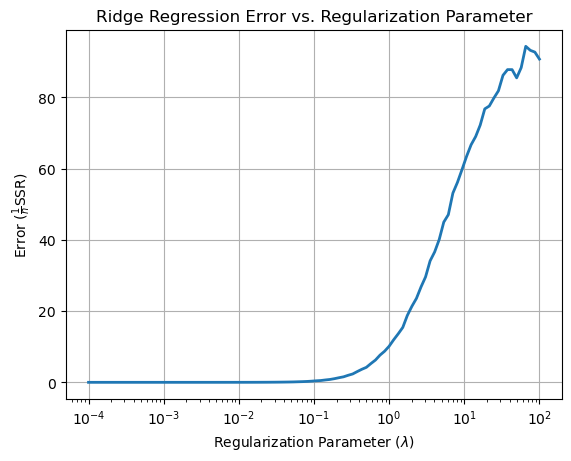

In [70]:
# Parameters of randomly-generated least squares problems
n = 50
p = 100
sig = 0.1

# We consider 100 regularization parameters logarithmically spaced between 1e-4 and 1e2
lams = np.logspace(-4, 2, 100)

# Initialize empty array of 100 corresponding errors
errors = np.zeros(len(lams))

# Compute average errors (across several trials) for each regularization parameter (lambda)
for i in range(len(lams)):
    # Run 100 trials per given regularization parameter (i.e., per lambda) and compute the average error to smooth out plot
    errors_given_lam = np.zeros(100)
    for j in range(len(errors_given_lam)):
        y, X, b = gen_lstsq(n, p, sig)
        bhat = solve_ridge_opt(X, y, lams[i])
        errors_given_lam[j] = err(X, y, bhat)
    errors[i] = np.mean(errors_given_lam)

# Plotting
plt.plot(lams, errors, linewidth = 2)
plt.xlabel(r"Regularization Parameter ($\lambda$)")
plt.ylabel(r"Error ($\frac{1}{n}$SSR)")
plt.title("Ridge Regression Error vs. Regularization Parameter")
plt.semilogx()
plt.grid()



### Part C: Analysis (optional - no points)

Find an analytic expression for the true solution to the ridge regression problem in terms of $X,$ $\lambda,$ and $y.$

### Part D: SVD (optional - no points)

Use the SVD to solve $X*b = y.$ Do this by forming the SVD of $X = U\Sigma V^T.$ Set $b = V z$ where $V$ is the $p\times n$ matrix consisting of the first $n$ right singular vectors (why?). Then, the system you get is $U \Sigma z = y.$ You can solve it by applying $U^T$ to both sides (why?) and noting that $\Sigma$ is diagonal. 

Note that you should be using the version of the SVD which (for $n<p$ but $X$ having full rank) gives $U$ as an $n\times n$ matrix, $\Sigma$ as an $n\times n$ diagonal matrix, and $V$ as a $p \times n$ matrix.